In [115]:
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "svg"

In [116]:
def createPreferenceGraph() :
    strings = ["prefers to collaborate with", "prefers to socialize with", "avoids to collaborate with",
           "avoids to socialize with", "perceives that the node ? prefers to collaborate with him", 
           "perceives that the node ? prefers to socialize with him", 
           "perceives that the node ? avoids to collaborate with him", 
           "perceives that the node ? avoids to socialize with him"]
    
    def editString(s, node1, node2) :
        if "?" in s :
            return f"node {node1} {str(node2).join(s.split('?'))}"
        else :
            return f"node {node1} {s} node {node2}"

    n = 100
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    for node in G.nodes() :
        nodes = list(filter(lambda item : item != node, G.nodes()))
        neighbors = np.random.choice(nodes, 8, replace=False)
        weights = np.random.choice(strings, 8, replace=False)
        for i,j in zip(neighbors, weights) :
            G.add_edge(int(node), int(i), opinion=editString(j, node, i))

    return G
        

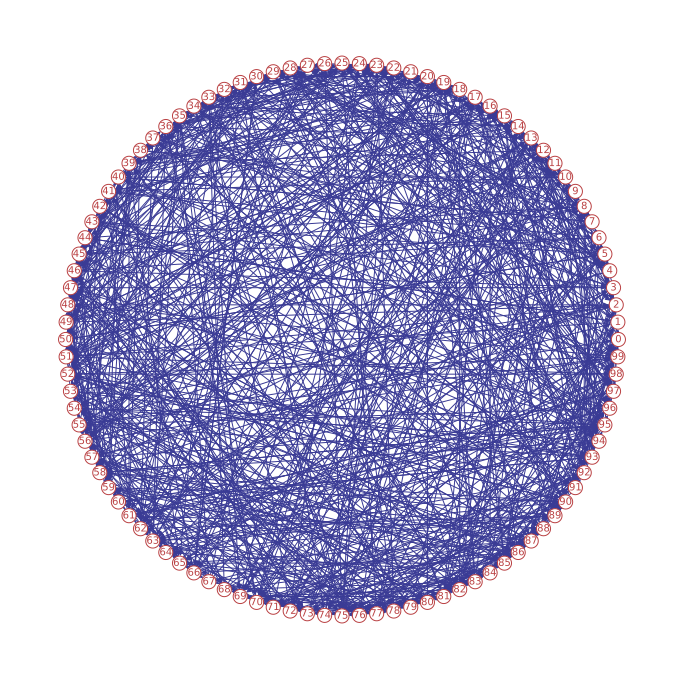

In [117]:
G = createPreferenceGraph()
plt.figure(figsize=(12,12))
plt.axis('equal')
options = {
            "node_color": "white",
            "edgecolors": "#b94042",
            "linewidths": 1,
            "node_size": 200,
            "edge_color": "#3a3b95",
            "font_size": 10,
            "font_color": '#b94042'
            }
nx.draw_circular(G, with_labels=True, **options)

In [118]:
for u, v, data in G.edges(data=True):
    print(data["opinion"])

node 0 avoids to collaborate with node 89
node 0 prefers to collaborate with node 91
node 0 perceives that the node 27 avoids to collaborate with him
node 0 perceives that the node 72 prefers to collaborate with him
node 0 prefers to socialize with node 97
node 0 avoids to socialize with node 6
node 0 perceives that the node 13 prefers to socialize with him
node 0 perceives that the node 69 avoids to socialize with him
node 1 perceives that the node 20 prefers to socialize with him
node 1 perceives that the node 78 avoids to socialize with him
node 1 perceives that the node 92 avoids to collaborate with him
node 1 perceives that the node 51 prefers to collaborate with him
node 1 prefers to socialize with node 44
node 1 avoids to collaborate with node 24
node 1 prefers to collaborate with node 71
node 1 avoids to socialize with node 31
node 2 prefers to socialize with node 83
node 2 prefers to collaborate with node 11
node 2 avoids to collaborate with node 57
node 2 perceives that the n

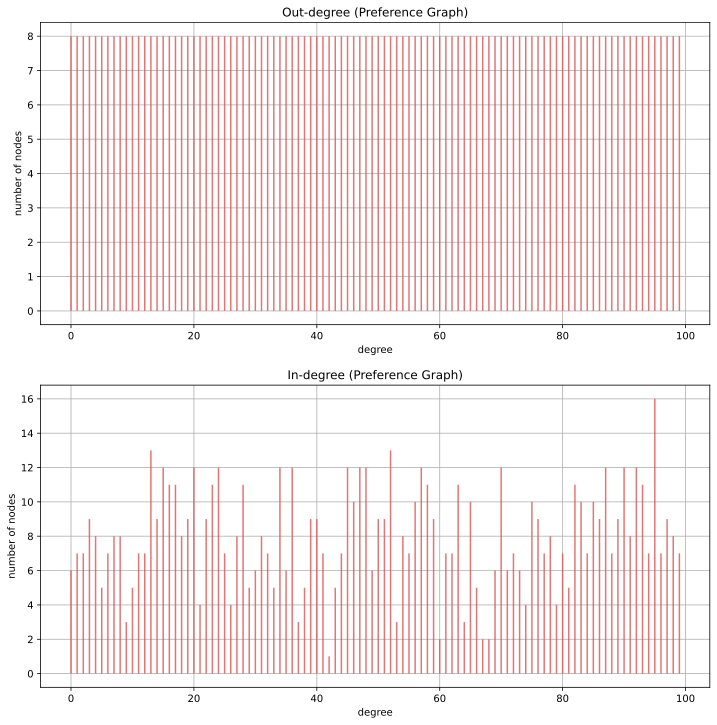

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
degrees = [dict(G.out_degree()), dict(G.in_degree())]

for i in range(2) :
    ax[i].vlines(x=list(degrees[i].keys()), ymin=0, ymax=list(degrees[i].values()), color="#DB5454", alpha=0.8)
    ax[i].grid(True)
    ax[i].set_title(f"{['Out-degree', 'In-degree'][i]} (Preference Graph)")
    ax[i].set_xlabel("degree")
    ax[i].set_ylabel("number of nodes")

In [120]:
def saveGraphJson(G, path) :
    def convertToJSON(G) :
        nodes = [{"id": node} for node in G.nodes()]
        
        edges = [{
            "source": i,
            "target": j,
            "comment": data["opinion"]
        } for i, j, data in G.edges(data=True)]

        return {
            "nodes": nodes,
            "edges": edges
        }
    with open(path, "w") as write_file:
        json.dump(convertToJSON(G), write_file)


In [121]:
saveGraphJson(G, "./preferenceGraph.json")

In [122]:
import re
from collections import Counter

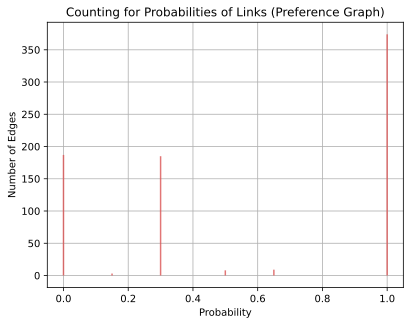

In [123]:
def calculateProbability(weight) :
    if re.match(r".*prefers.*collaborate.*|.*prefers.*socialize.*", weight) :
        return 1
    elif re.match(r".*perceives.*prefers.*collaborate.*|.*perceives.*prefers.*socialize.*", weight) :
        return 0.7
    elif re.match(r".*perceives.*avoids.*collaborate.*|.*perceives.*avoids.*socialize.*", weight) :
        return 0.3
    else :
        return 0
        

#dictionary {edge : probability of existing in the Preference Graph}
edgesProbabilities = {}

#examine each eage in Preference Graph
#calculate probability
for u, v in G.edges() :
    if G.has_edge(v, u) :
    #(u,v) and (v,u) are checked together once
        if (v,u) in edgesProbabilities :
            #(v,u) is already checked, so neglect (u,v)
            continue 
        else :
            #(u,v), (v,u) pair has not been checked
            edgesProbabilities[(u,v)] = 0.5*(calculateProbability(G[u][v]["opinion"]) + calculateProbability(G[v][u]["opinion"]))
    else :
        edgesProbabilities[(u,v)] = calculateProbability(G[u][v]["opinion"])



fig, ax = plt.subplots()
count = Counter(edgesProbabilities.values())

ax.vlines(x=list(count.keys()), ymin=0, ymax=list(count.values()), color="#DB5454", alpha=0.8)
ax.grid(True)
ax.set_title(f"Counting for Probabilities of Links (Preference Graph)")
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Edges")
plt.show()